## Create final plot showing remaining need, based on ndc children served compared to estimated children <4 in TennCare.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
#import NDC deliveries csv
county_stats = pd.read_csv('../files/county_stats.csv')
county_stats.head()

,County,Total Population,Population Age 0-4,Population Age 5-9,Population Age 0-9,# Households,# Live Births,Est # in Diapers,Est. TennCare,Household Income (Avg),% Title 1 Schools,% Food Stamp,% Poverty Rate 0-17,% Poverty Rate All Ages,Pop in Poverty <17,Pop in Poverty Tot,In Diapers in Poverty,diapers used,Diaper cost/month,$ per county/month for low income
0,Davidson,"667,885","46,539","41,537","88,076","269,078","9,962","34,904","12,453","$60,388",63.42%,14.60%,25.40%,15.40%,169643.0,102854.0,6325.870,1518208.80,$80.00,"$442,810.90"
1,Williamson,"205,645","12,451","16,755","29,206","71,043","2,321","9,338","2,901","$112,962",17.74%,3.40%,3.50%,3.80%,7198.0,7815.0,203.105,48745.20,$80.00,"$14,217.35"
2,Montgomery,"189,709","16,476","14,404","30,880","67,090","3,512","12,357","4,390","$57,541",61.70%,13.20%,16.60%,12.00%,31492.0,22765.0,1457.480,349795.20,$80.00,"$102,023.60"
3,Maury,"85,767","5,730","6,077","11,807","32,889","1,184","4,298","1,480","$57,170",64.20%,16.40%,15.20%,10.80%,13037.0,9263.0,449.920,107980.80,$80.00,"$31,494.40"
4,Hickman,"24,251","1,291","1,553","2,844","8,855",257,968,321,"$43,596",88.89%,22.70%,24.20%,16.30%,5869.0,3953.0,155.606,37345.44,$80.00,"$10,892.42"


In [3]:
#only keep needed columns
county_stats = county_stats[['County',
                             'Population Age 0-4',
                             'Est # in Diapers',
                             'Est. TennCare',
                             'In Diapers in Poverty',
                             'diapers used'
                            ]].copy()
county_stats.tail()

,County,Population Age 0-4,Est # in Diapers,Est. TennCare,In Diapers in Poverty,diapers used
7,Rutherford,"19,515","14,636","5,183",1285.2600,308462.40
8,Cheatham,"2,237","1,678",563,151.8750,36450.00
9,Wilson,"7,549","5,662",2064,408.6225,98069.40
10,Total,"110,312","82,734","28,890",11048.4400,2651625.24
11,Other Counties,"63,773","47,830","16,437",NaN,NaN


In [4]:
#rename columns
county_stats = county_stats.rename(columns = {'County':'county',
                                              'Population Age 0-4':'pop_under_4',
                                              'Est # in Diapers':'est_in_diapers',
                                              'Est. TennCare':'est_in_tenncare',
                                              'In Diapers in Poverty':'diapers_and_poverty',
                                              'diapers used':'diapers_used'
                                             })
county_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   county               12 non-null     object 
 1   pop_under_4          12 non-null     object 
 2   est_in_diapers       12 non-null     object 
 3   est_in_tenncare      12 non-null     object 
 4   diapers_and_poverty  11 non-null     float64
 5   diapers_used         11 non-null     float64
dtypes: float64(2), object(4)
memory usage: 704.0+ bytes


In [5]:
#drop unneeded rows
county_stats = county_stats.drop(county_stats.index[[1,2,3,4,5,6,7,8,9,10]]).reset_index()
county_stats = county_stats.drop(columns=['index'])
county_stats

,county,pop_under_4,est_in_diapers,est_in_tenncare,diapers_and_poverty,diapers_used
0,Davidson,"46,539","34,904","12,453",6325.87,1518208.8
1,Other Counties,"63,773","47,830","16,437",NaN,NaN


In [6]:
#drop some more columns
county_stats = county_stats.drop(columns=['est_in_tenncare', 'diapers_and_poverty', 'diapers_used'])
#convert columns to integers
county_stats['pop_under_4'] = county_stats['pop_under_4'].str.replace(',', '').astype(int)
county_stats['est_in_diapers'] = county_stats['est_in_diapers'].str.replace(',', '').astype(int)
#add some columns (16.5% from https://www.sycamoreinstitutetn.org/census-tn-economy-2018/)
#change to 50% - https://www.kff.org/medicaid/state-indicator/births-financed-by-medicaid/
county_stats['diaper_pov'] = county_stats['est_in_diapers']*.5
county_stats['diaper_pov'] = county_stats['diaper_pov'].astype(int)
county_stats

,county,pop_under_4,est_in_diapers,diaper_pov
0,Davidson,46539,34904,17452
1,Other Counties,63773,47830,23915


In [7]:
#import NDC deliveries csv
total_by_county = pd.read_csv('../files/total_by_county.csv')
total_by_county

,County,Total
0,"Davidson, TN",1817313
1,"Marshall, TN",2025
2,"Maury, TN",1475
3,"Washington, TN",3750
4,"Williamson, TN",6050
5,"Wilson, TN",10550
6,Total,1841163
7,Other Counties,20100


In [8]:
#strip TN from counties and rename
total_by_county['County'] = total_by_county['County'].str.split(',').str[0]
total_by_county = total_by_county.rename(columns = {'County':'county',
                                              'Total':'total'
                                             })
total_by_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   county  8 non-null      object
 1   total   8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [9]:
#drop unneeded rows
#df.drop(df.index[[2,3]])
total_by_county=total_by_county.drop(total_by_county.index[[1,2,3,4,5,6]]).reset_index()
total_by_county = total_by_county.drop(columns=['index'])
total_by_county

,county,total
0,Davidson,1817313
1,Other Counties,20100


In [10]:
#merge datasets
remaining_need = pd.merge(county_stats, total_by_county, on = 'county', how = 'inner')
remaining_need

,county,pop_under_4,est_in_diapers,diaper_pov,total
0,Davidson,46539,34904,17452,1817313
1,Other Counties,63773,47830,23915,20100


In [11]:
#add diapers_per_day column
remaining_need['diapers_per_day'] = remaining_need['total']*.0030303
remaining_need['diapers_per_day'] = remaining_need['diapers_per_day'].astype(int)
remaining_need

,county,pop_under_4,est_in_diapers,diaper_pov,total,diapers_per_day
0,Davidson,46539,34904,17452,1817313,5507
1,Other Counties,63773,47830,23915,20100,60


In [12]:
#add children_covered column
remaining_need['children_covered'] = remaining_need['diapers_per_day']/10
remaining_need['children_covered'] = remaining_need['children_covered'].astype(int)
remaining_need

,county,pop_under_4,est_in_diapers,diaper_pov,total,diapers_per_day,children_covered
0,Davidson,46539,34904,17452,1817313,5507,550
1,Other Counties,63773,47830,23915,20100,60,6


In [13]:
#add remaining_need column
remaining_need['remaining_need'] = remaining_need['diaper_pov']-remaining_need['children_covered']
remaining_need['remaining_need'] = remaining_need['remaining_need'].astype(int)
remaining_need

,county,pop_under_4,est_in_diapers,diaper_pov,total,diapers_per_day,children_covered,remaining_need
0,Davidson,46539,34904,17452,1817313,5507,550,16902
1,Other Counties,63773,47830,23915,20100,60,6,23909


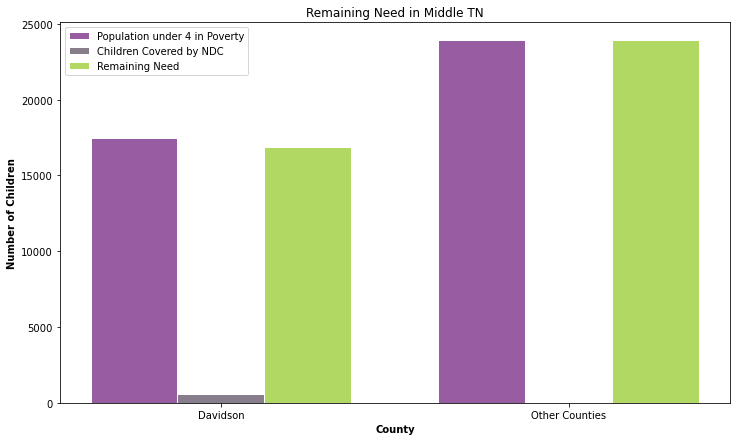

In [14]:
plt.figure(figsize=(12,7))

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = remaining_need['diaper_pov']
bars2 = remaining_need['children_covered']
bars3 = remaining_need['remaining_need']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
## 
# Make the plot
rects1 = plt.bar(r1, bars1, color='#985ca3', width=barWidth, edgecolor='white', label='Population under 4 in Poverty')
rects2 = plt.bar(r2, bars2, color='#887d8b', width=barWidth, edgecolor='white', label='Children Covered by NDC')
rects3 = plt.bar(r3, bars3, color='#b1d863', width=barWidth, edgecolor='white', label='Remaining Need')

# Add xticks on the middle of the group bars
plt.xlabel('County', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], remaining_need['county'], rotation=0)

plt.ylabel('Number of Children', fontweight='bold')

plt.title('Remaining Need in Middle TN')
 
# Create legend & Show graphic
plt.legend()

plt.savefig('../files/remaining_need.png',bbox_inches='tight', dpi=300)
#plt.savefig('../files/remaining_need.pdf')
plt.show()
